# Spectra binned by energy
- Compute cinetic nrj on 60 days time window using pynsitu.drifters.time_window_processing
- average spectra computed in parquet_time_window_spectra.ipynb binning on cinetic nrj
- store it in zarr

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import geopandas as gpd
# from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt

import drifters.utils as ut
import pynsitu as pin
from GDP_lib import root_dir

In [2]:
from dask.distributed import Client

if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster

    # cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    # cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=3, processes=3, walltime="04:00:00")
    w = cluster.scale(jobs=8)
    # from dask_jobqueue import PBSCluster
    # cluster = PBSCluster()
    # w = cluster.scale(jobs=8) # 5 for gps, 8 for argos
else:
    from dask.distributed import LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.72:8787/status,
Dashboard: http://10.148.0.72:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.72:44260,Workers: 0
Dashboard: http://10.148.0.72:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Choose key 

In [3]:
key = "gps"  # 'gps' or 'argos'
key2 = "_corrected"  # or '_corrected'

___
# Generate 60 days window mean cinetic nrj

In [4]:
# drop all variables but relevant ones
col = [
    "id",
    "time",
    "lon",
    "lat",
    "x",
    "y",
    "ve",
    "vn",
    "ae",
    "an",
    "vex",
    "vny",
    "aex",
    "any",
    "ae_vex",
    "an_vny",
    "vex_diff",
    "vny_diff",
    "err_lon",
    "err_lat",
    "err_ve",
    "err_vn",
]

In [5]:
# LOAD files with velocities and accelerations computed
parquet = os.path.join(root_dir, key + "_av_time" + key2 + ".parquet")
df = dd.read_parquet(parquet).reset_index()[col].persist()
df = df.rename(columns={"time": "date"})
df["ven2"] = df.ve**2 + df.vn**2

# add time in hours
time_unit = pd.Timedelta("1H")
t_ref = pd.Timestamp(2000, 1, 1)
df["time"] = (df["date"] - t_ref) / time_unit

T_str = "60D"  # days, time window given to pin.drifters.time_window_processing
dt = "1H"  # sampling

N = int(pd.Timedelta(T_str) / pd.Timedelta(dt))  # output size
T = pd.Timedelta(T_str) / time_unit  # must be in the same units than time


def nrj(lon, lat, ve, vn, N, dt):
    # print(f'lon: {lon},\n lat:{lat},\n ve:{ve},\n vn:{vn},\n N : {N}, dt:{dt}\n \n')
    if ve is None:
        return pd.Series(0.1)
    else:
        # print(np.sqrt(ve**2+ vn**2))
        return pd.Series((ve**2 + vn**2).mean())


def process_uv(lon, lat, u, v, N, dt, **kwargs):
    """Wraps spectral calculation: add complex velocity
    Assumes the time series is regularly sampled

    Parameters:
    -----------
        u, v: pd.Series
            zonal, meridional index by time (in days)
        N: int,
            length of the spectrum
        dt: float
            Time sampling in days
        **kwargs:
            passed to mit_equinox.drifters.get_spectrum
    """
    if lon is None:
        uv = None
    else:
        uv = u + 1j * v
    return pin.tseries.get_spectrum(uv, N, dt=dt, **kwargs)


# pin.drifters.
group = tuple(df.get_partition(0)["id"].loc[0].values.compute())[0]
dfg = df.groupby("id").get_group(group).compute()

outs = pin.drifters.time_window_processing(
    dfg, process_uv, ["lon", "lat", "ve", "vn"], T, N, id_label="id", dt=dt, geo=True
)
out = pin.drifters.time_window_processing(
    dfg, nrj, ["lon", "lat", "ve", "vn"], T, N=1, id_label="id", dt=dt, geo=True
)

df_nrj = df.groupby("id").apply(
    pin.drifters.time_window_processing,
    nrj,
    ["lon", "lat", "ve", "vn"],
    T,
    N=1,
    id_label="id",
    dt=dt,
    geo=True,
    meta=out,
)
df_nrj = (
    df_nrj.rename(columns={"x": "lon", "y": "lat", 0: "ven2"})
    .repartition(partition_size="100MB")
    .persist()
)

In [6]:
out

,x,y,id,0
13850.0,-91.664059,3.558864,22192.0,0.078472
14570.0,-92.556271,2.910508,22192.0,0.116655
15290.0,-100.531712,1.245543,22192.0,0.368485
16010.0,-110.107266,-1.717577,22192.0,0.308725


In [7]:
outs

,x,y,id,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,...,-0.16666666666666666,-0.15,-0.13333333333333333,-0.11666666666666667,-0.1,-0.08333333333333333,-0.06666666666666667,-0.05,-0.03333333333333333,-0.016666666666666666
13850.0,-91.664059,3.558864,22192.0,0.089993,0.007925,0.080207,0.036749,0.007239,0.003791,0.001309,...,0.021432,0.149978,0.347112,0.446985,0.216979,0.047483,0.068371,0.133665,0.071354,0.007634
14570.0,-92.556271,2.910508,22192.0,0.582165,0.398766,0.043822,0.005096,0.006477,0.012879,0.015144,...,0.053474,0.032386,0.111352,0.197273,0.263843,0.162328,0.054595,0.139463,0.051812,0.510923
15290.0,-100.531712,1.245543,22192.0,13.875751,5.595187,0.507043,0.221491,0.020230,0.030312,0.019948,...,0.087056,0.029171,0.035611,0.100678,0.079065,0.103643,0.248163,0.082820,0.286755,2.936012
16010.0,-110.107266,-1.717577,22192.0,3.576124,0.725300,3.346217,2.425059,0.498373,0.164430,0.094403,...,0.006931,0.010905,0.010974,0.025010,0.083454,0.176001,0.194727,0.144771,0.461444,0.618104


integration by sum*df do not give the correct nrj

In [8]:
(dfg.ve**2 + dfg.vn**2).mean()

0.18891878

In [9]:
df_nrj_ = df_nrj.get_partition(0).compute()
df_nrj_

,lon,lat,id,ven2
102896.0,63.393408,-46.719788,10307870.0,0.116418
103616.0,69.921751,-45.185127,10307870.0,0.121205
104336.0,73.808273,-44.733946,10307870.0,0.115740
105056.0,79.420448,-44.025517,10307870.0,0.181883
107150.0,-48.554713,50.181069,11020180.0,0.052866
...,...,...,...,...
176543.0,-139.031718,39.783372,66614860.0,0.090951
175128.0,-175.778934,-21.038261,67242750.0,0.051232
175848.0,-177.312066,-23.605411,67242750.0,0.087121
176568.0,-179.269100,-25.497504,67242750.0,0.143756


____
# Load 60 days window spectra (generation in parquet_time_window_spectra.ipynb)

In [13]:
root_dir = "/home1/datawork/mdemol/GDP"
labels = [
    "ven",
    "aen",
    "vxy",
    "axy",
    "vxydiff",
    "xy",
    "err_lonlat",
    "err_lonlatm",
    "err_vevn",
    "avxy",
]


def load_spectra(root_dir=root_dir):
    DF = {}
    for var_key in labels:
        parquet = os.path.join(
            root_dir, key + "_" + var_key + "_spectra" + key2 + ".parquet"
        )
        DF[var_key] = dd.read_parquet(parquet).persist()
    return DF


DF = load_spectra()

In [14]:
DF["ven"]

Dask DataFrame Structure:
                   lon      lat       id      0.0 0.016666666666666666 0.03333333333333333     0.05 0.06666666666666667 0.08333333333333333      0.1 0.11666666666666667 0.13333333333333333     0.15 0.16666666666666666 0.18333333333333332      0.2 0.21666666666666667 0.23333333333333334     0.25 0.26666666666666666 0.2833333333333333      0.3 0.31666666666666665 0.3333333333333333     0.35 0.36666666666666664 0.3833333333333333      0.4 0.4166666666666667 0.43333333333333335     0.45 0.4666666666666667 0.48333333333333334      0.5 0.5166666666666666 0.5333333333333333     0.55 0.5666666666666667 0.5833333333333334      0.6 0.6166666666666667 0.6333333333333333     0.65 0.6666666666666666 0.6833333333333333      0.7 0.7166666666666667 0.7333333333333333     0.75 0.7666666666666666 0.7833333333333333      0.8 0.8166666666666667 0.8333333333333334     0.85 0.8666666666666667 0.8833333333333333      0.9 0.9166666666666666 0.9333333333333333     0.95 0.9666666666666667 0.9833333333333333      1.0 1.0166666666666666 1.0333333333333332     1.05 1.0666666666666667 1.0833333333333333      1.1 1.1166666666666667 1.1333333333333333     1.15 1.1666666666666667 1.1833333333333333      1.2 1.2166666666666666 1.2333333333333334     1.25 1.2666666666666666 1.2833333333333332      1.3 1.3166666666666667 1.3333333333333333     1.35 1.3666666666666667 1.3833333333333333      1.4 1.4166666666666667 1.4333333333333333     1.45 1.4666666666666666 1.4833333333333334      1.5 1.5166666666666666 1.5333333333333332     1.55 1.5666666666666667 1.5833333333333333      1.6 1.6166666666666667 1.6333333333333333     1.65 1.6666666666666667 1.6833333333333333      1.7 1.7166666666666666 1.7333333333333334     1.75 1.7666666666666666 1.7833333333333332      1.8 1.8166666666666667 1.8333333333333333 1.8499999999999999 1.8666666666666667 1.8833333333333333      1.9 1.9166666666666667 1.9333333333333333     1.95 1.9666666666666666 1.9833333333333334      2.0 2.0166666666666666 2.033333333333333     2.05 2.0666666666666664 2.0833333333333335      2.1 2.1166666666666667 2.1333333333333333     2.15 2.1666666666666665 2.183333333333333      2.2 2.216666666666667 2.2333333333333334     2.25 2.2666666666666666 2.283333333333333      2.3 2.3166666666666664 2.3333333333333335     2.35 2.3666666666666667 2.3833333333333333      2.4 2.4166666666666665 2.433333333333333     2.45 2.466666666666667 2.4833333333333334      2.5 2.5166666666666666 2.533333333333333     2.55 2.5666666666666664 2.5833333333333335      2.6 2.6166666666666667 2.6333333333333333     2.65 2.6666666666666665 2.683333333333333      2.7 2.716666666666667 2.7333333333333334     2.75 2.7666666666666666 2.783333333333333      2.8 2.8166666666666664 2.8333333333333335     2.85 2.8666666666666667 2.8833333333333333      2.9 2.9166666666666665 2.933333333333333     2.95 2.966666666666667 2.9833333333333334      3.0 3.0166666666666666 3.033333333333333     3.05 3.0666666666666664 3.0833333333333335      3.1 3.1166666666666667 3.1333333333333333     3.15 3.1666666666666665 3.183333333333333      3.2 3.216666666666667 3.2333333333333334     3.25 3.2666666666666666 3.283333333333333      3.3 3.3166666666666664 3.3333333333333335     3.35 3.3666666666666667 3.3833333333333333      3.4 3.4166666666666665 3.433333333333333 3.4499999999999997 3.466666666666667 3.4833333333333334      3.5 3.5166666666666666 3.533333333333333     3.55 3.5666666666666664 3.5833333333333335      3.6 3.6166666666666667 3.6333333333333333     3.65 3.6666666666666665 3.683333333333333 3.6999999999999997 3.716666666666667 3.7333333333333334     3.75 3.7666666666666666 3.783333333333333      3.8 3.8166666666666664 3.8333333333333335     3.85 3.8666666666666667 3.8833333333333333      3.9 3.9166666666666665 3.933333333333333 3.9499999999999997 3.966666666666667 3.9833333333333334      4.0 4.016666666666667 4.033333333333333     4.05 4.066666666666666 4.083333333333333      4.1 4.116666666666666 4.133333333333333     4.

___
# Merge nrj in the dataset

In [15]:
# Verify we can merge
(DF["ven"].lon.compute() == df_nrj.lon.compute()).all()

True

In [16]:
# Verify we can merge
(DF["ven"].index.compute() == df_nrj.index.compute()).all()

True

In [17]:
df_nrj = df_nrj.set_index("lon")
for l in DF:
    DF[l] = DF[l].set_index("lon")
    DF[l]["ven2"] = df_nrj["ven2"]

In [18]:
DF["ven"].tail()

,lat,id,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,0.11666666666666667,...,-0.13333333333333333,-0.11666666666666667,-0.1,-0.08333333333333333,-0.06666666666666667,-0.05,-0.03333333333333333,-0.016666666666666666,date,ven2
lon,,,,,,,,,,,,,,,,,,,,,
179.958328,-43.963244,62818740.0,0.183578,0.037919,0.046813,0.042172,0.026172,0.004148,0.005447,0.027596,...,0.002155,0.002507,0.001965,0.003425,0.004812,0.000806,0.008808,0.030968,2015-12-29 11:00:00,0.052723
179.969153,45.467222,65707970.0,0.011784,0.009432,0.003505,0.006869,0.003132,0.001293,0.001042,0.007936,...,0.030732,0.007153,0.009108,0.007027,0.010934,0.024154,0.019455,0.000934,2019-04-21 08:00:00,0.037409
179.972445,-46.318394,62839800.0,0.084864,0.219800,0.068532,0.011469,0.005099,0.003094,0.004912,0.012383,...,0.000015,0.002875,0.002837,0.020170,0.029089,0.008633,0.019409,0.006847,2016-09-17 15:00:00,0.037986
179.985673,34.663516,60959420.0,0.653801,0.530842,0.783728,0.495673,0.110888,0.051868,0.033811,0.077786,...,0.123538,0.061878,0.418971,0.219660,0.085159,0.003387,0.646225,1.715286,2015-05-16 20:00:00,0.165933
179.985808,52.237484,62414690.0,0.012089,0.014703,0.052181,0.052221,0.011218,0.005724,0.000851,0.014194,...,0.029930,0.079648,0.004870,0.012105,0.005427,0.283060,0.413616,0.025072,2016-12-14 08:00:00,0.220176


___
# Nrj BINS 

<AxesSubplot: >

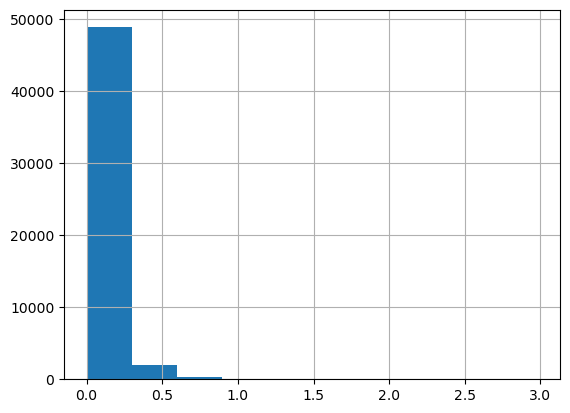

In [19]:
DF["ven"].ven2.compute().hist()

In [20]:
DF["ven"].ven2.quantile(0.9).compute()

0.29069898426532753

In [21]:
# Define bins
dn = 0.025
nrj_bins = np.arange(0, 0.5, dn)
# define a label
nrj_center = nrj_bins[:-1] + dn / 2
len(nrj_bins)

20

In [22]:
DF_nrj = {}
Ds = {}
for l in DF:
    DF[l]["ven2_cut"] = DF[l]["ven2"].map_partitions(pd.cut, bins=nrj_bins)
    DF_nrj[l] = (
        DF[l].groupby(["ven2_cut"]).mean().compute()
    )  # MEAN SPECTRUM OVER ALL SEGMENT IN THE NRJ bins
    # Converting pandas dataframe in xarray dataset:
    index = DF_nrj[l].index.map(lambda v: v.mid).rename("ven2_cut")

    ds = (
        (
            pd.melt(
                DF_nrj[l]
                .set_index(index)
                .drop(columns=["id", "lat", "ven2"])
                .reset_index(),
                id_vars=[
                    "ven2_cut",
                ],
                var_name="frequency",
            ).rename(columns={"ven2_cut": "ven2", "value": "E_" + l})
        )
        .to_xarray()
        .set_index(index=["ven2", "frequency"])
        .unstack()
    )
    ds["frequency"] = ds["frequency"].astype(float)
    ds = ds.sortby("frequency")
    # ds = ds.chunk({'frequency': 100})
    Ds[l] = ds
    print(l)

# nb counts
dsc = (
    DF[l]
    .groupby(["ven2_cut"])
    .size()
    .compute()
    .to_frame("nb_window_bins")
    .set_index(index)
    .reset_index()
    .to_xarray()
    .rename({"ven2_cut": "ven2"})
    .set_index(index=["ven2"])
    .rename({"index": "ven2"})
    .unstack()
)

ven
aen
vxy
axy
vxydiff
xy
err_lonlat
err_lonlatm
err_vevn
avxy


In [23]:
Ds["ven"]

<xarray.Dataset>
Dimensions:    (ven2: 19, frequency: 1440)
Coordinates:
  * ven2       (ven2) float64 0.0125 0.0375 0.0625 ... 0.4125 0.4375 0.4625
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
Data variables:
    E_ven      (ven2, frequency) float64 4.713e-06 4.48e-06 ... 6.228e-05

In [24]:
dsc

<xarray.Dataset>
Dimensions:         (ven2: 19)
Coordinates:
  * ven2            (ven2) float64 0.0125 0.0375 0.0625 ... 0.4125 0.4375 0.4625
Data variables:
    nb_window_bins  (ven2) int64 3571 10792 10271 7857 5195 ... 191 174 135 116

In [25]:
ds = xr.merge(list(Ds.values()) + [dsc])

# set attrs
ds.E_xy.attrs = {
    "long_name": "Power density spectra X = x + jy",
    "units": r"$m^2/cpd$",
    "description": "LOWESS method",
}
ds.E_ven.attrs = {
    "long_name": "Power density spectra v = ve + jvn",
    "units": r"$m^2/s^2/cpd$",
    "description": "LOWESS method",
}
ds.E_vxy.attrs = {
    "long_name": "Power density spectra v = vx + jvy",
    "units": r"$m^2/s^2/cpd$",
    "description": "geoid method",
}
ds.E_vxydiff.attrs = {
    "long_name": "Power density spectra v = vx + jvy",
    "units": r"$m^2/s^2/cpd$",
    "description": "finite differentiation method",
}
ds.E_axy.attrs = {
    "long_name": "Power density spectra a = ax + jay",
    "units": r"$m^2/s^4/cpd$",
    "description": "from position",
}
ds.E_aen.attrs = {
    "long_name": "Power density spectra a = ae + jan",
    "units": r"$m^2/s^4/cpd$",
    "description": "from ve,vn",
}

ds.frequency.attrs = {"long_name": "frequency", "units": "cpd"}
ds.nb_window_bins.attrs = {
    "long_name": "nb_geobins",
    "description": "number of T days time window spectra per bins",
}

ds["E_venw2"] = ds["E_ven"] * (ds["frequency"] * 2 * np.pi / 3600 / 24) ** 2
ds["E_vxyw2"] = ds["E_vxy"] * (ds["frequency"] * 2 * np.pi / 3600 / 24) ** 2

ds.E_venw2.attrs = {
    "long_name": "E_ven $  \omega^2$",
    "units": r"$m^2/s^4/cpd$",
    "description": "from position",
}
ds.E_vxyw2.attrs = {
    "long_name": "E_vxy $  \omega^2$",
    "units": r"$m^2/s^4/cpd$",
    "description": "from ve,vn",
}

In [26]:
ds

<xarray.Dataset>
Dimensions:         (ven2: 19, frequency: 1440)
Coordinates:
  * ven2            (ven2) float64 0.0125 0.0375 0.0625 ... 0.4125 0.4375 0.4625
  * frequency       (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
Data variables: (12/13)
    E_ven           (ven2, frequency) float64 4.713e-06 4.48e-06 ... 6.228e-05
    E_aen           (ven2, frequency) float64 6.16e-16 6.39e-16 ... 4.748e-16
    E_vxy           (ven2, frequency) float64 6.952e-08 7.64e-08 ... 3.495e-06
    E_axy           (ven2, frequency) float64 2.645e-12 2.598e-12 ... 1.164e-11
    E_vxydiff       (ven2, frequency) float64 7.064e-08 7.771e-08 ... 3.671e-06
    E_xy            (ven2, frequency) float64 216.4 215.3 ... 1.659e+03 491.2
    ...              ...
    E_err_lonlatm   (ven2, frequency) float64 6.069e+07 5.671e+07 ... 14.13
    E_err_vevn      (ven2, frequency) float64 2.708e-06 2.207e-06 ... 1.187e-05
    E_avxy          (ven2, frequency) float64 7.378e-14 7.461e-14 ... 2.516e-13
    nb_window_bins  (ven2) int64 3571 10792 10271 7857 5195 ... 191 174 135 116
    E_venw2         (ven2, frequency) float64 3.589e-12 3.402e-12 ... 4.729e-11
    E_vxyw2         (ven2, frequency) float64 5.295e-14 5.802e-14 ... 2.654e-12

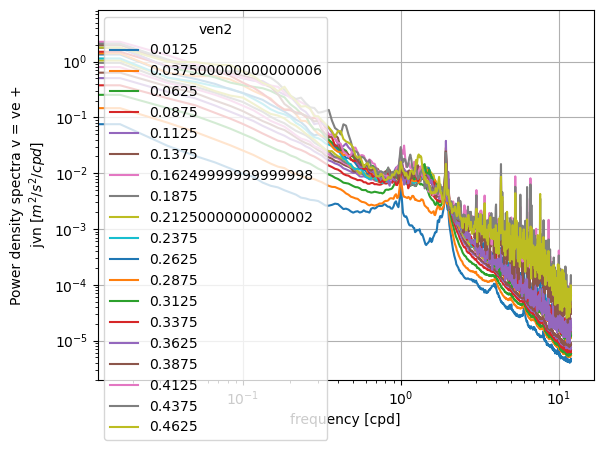

In [27]:
ds.E_ven.plot(hue="ven2")
plt.xscale("log")
plt.yscale("log")
plt.grid()


# Store nrj spectra

In [28]:
root_dir = "/home1/datawork/mdemol/GDP"
zarr = os.path.join(
    root_dir, key + "_nrjspectra_" + str(dn).replace(".", "") + key2 + ".zarr"
)
ds.to_zarr(zarr, mode="w")

In [29]:
ds_reload = xr.open_zarr(zarr).persist()
ds_reload

<xarray.Dataset>
Dimensions:         (ven2: 19, frequency: 1440)
Coordinates:
  * frequency       (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
  * ven2            (ven2) float64 0.0125 0.0375 0.0625 ... 0.4125 0.4375 0.4625
Data variables: (12/13)
    E_aen           (ven2, frequency) float64 dask.array<chunksize=(19, 1440), meta=np.ndarray>
    E_avxy          (ven2, frequency) float64 dask.array<chunksize=(19, 1440), meta=np.ndarray>
    E_axy           (ven2, frequency) float64 dask.array<chunksize=(19, 1440), meta=np.ndarray>
    E_err_lonlat    (ven2, frequency) float64 dask.array<chunksize=(19, 1440), meta=np.ndarray>
    E_err_lonlatm   (ven2, frequency) float64 dask.array<chunksize=(19, 1440), meta=np.ndarray>
    E_err_vevn      (ven2, frequency) float64 dask.array<chunksize=(19, 1440), meta=np.ndarray>
    ...              ...
    E_venw2         (ven2, frequency) float64 dask.array<chunksize=(19, 1440), meta=np.ndarray>
    E_vxy           (ven2, frequency) float64 dask.array<chunksize=(19, 1440), meta=np.ndarray>
    E_vxydiff       (ven2, frequency) float64 dask.array<chunksize=(19, 1440), meta=np.ndarray>
    E_vxyw2         (ven2, frequency) float64 dask.array<chunksize=(19, 1440), meta=np.ndarray>
    E_xy            (ven2, frequency) float64 dask.array<chunksize=(19, 1440), meta=np.ndarray>
    nb_window_bins  (ven2) int64 dask.array<chunksize=(19,), meta=np.ndarray>

In [30]:
cluster.close()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min